Vasmos a cargar el dataset de AirBnB descargado de [aquí](https://public.opendatasoft.com/explore/dataset/airbnb-listings/export/?disjunctive.host_verifications&disjunctive.amenities&disjunctive.features&q=Madrid&dataChart=eyJxdWVyaWVzIjpbeyJjaGFydHMiOlt7InR5cGUiOiJjb2x1bW4iLCJmdW5jIjoiQ09VTlQiLCJ5QXhpcyI6Imhvc3RfbGlzdGluZ3NfY291bnQiLCJzY2llbnRpZmljRGlzcGxheSI6dHJ1ZSwiY29sb3IiOiJyYW5nZS1jdXN0b20ifV0sInhBeGlzIjoiY2l0eSIsIm1heHBvaW50cyI6IiIsInRpbWVzY2FsZSI6IiIsInNvcnQiOiIiLCJzZXJpZXNCcmVha2Rvd24iOiJyb29tX3R5cGUiLCJjb25maWciOnsiZGF0YXNldCI6ImFpcmJuYi1saXN0aW5ncyIsIm9wdGlvbnMiOnsiZGlzanVuY3RpdmUuaG9zdF92ZXJpZmljYXRpb25zIjp0cnVlLCJkaXNqdW5jdGl2ZS5hbWVuaXRpZXMiOnRydWUsImRpc2p1bmN0aXZlLmZlYXR1cmVzIjp0cnVlfX19XSwidGltZXNjYWxlIjoiIiwiZGlzcGxheUxlZ2VuZCI6dHJ1ZSwiYWxpZ25Nb250aCI6dHJ1ZX0%3D&location=16,41.38377,2.15774&basemap=jawg.streets)

![](descargar.png)

In [1]:
#install.packages("dplyr")
#install.packages('dplyr', repos = 'https://cloud.r-project.org')
#library(magrittr)
library(dplyr)
library(ggplot2)
options(repr.plot.height=8,repr.plot.width=16)
library(tidyverse)
library(dendextend)
library(cluster)
#library(glmnet)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


── Attaching packages ────────────────────────────────────────────────────────────────────── tidyverse 1.3.2 ──
✔ tibble  3.1.8     ✔ purrr   0.3.5
✔ tidyr   1.2.1     ✔ stringr 1.4.1
✔ readr   2.1.3     ✔ forcats 0.5.2
── Conflicts ───────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

---------------------
Welcome to dendextend version 1.16.0
Type citation('dendextend') for how to cite the package.

Type browseVignettes(package = 'dendextend') for the package vignette.
The github page is: https://github.com/talgalili/dendextend/

Suggestions and bug-reports can be submitted at: https://github.com/talgalili/dendextend/issues
You may ask questions at stackoverflow, use

In [2]:
airbnb<-read.csv('airbnb-listings.csv',sep = ';')
options(repr.plot.height=4,repr.plot.width=6,repr.plot.res = 300)

Vamos a quedarnos con las columnas de mayor interés:

'City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude'

In [36]:
airbnb <- airbnb[,c('City','Room.Type','Neighbourhood','Accommodates','Bathrooms','Bedrooms','Beds','Price','Square.Feet','Guests.Included','Extra.People','Review.Scores.Rating','Latitude', 'Longitude')]

Nos quedarmos solo con las entradas de Madrid para Room.Type=="Entire home/apt" y cuyo barrio (Neighbourhood) no está vacio ''
Podemos eliminar las siguientes columnas que ya no son necesarias:
"Room.Type",'City'

Llama a nuevo dataframe df_madrid.

In [4]:
paste('Cantidad de entradas iniciales: ', airbnb |> nrow())

df_madrid <- airbnb |> 
                filter(City == "Madrid") |> 
                filter(Room.Type == "Entire home/apt") |> 
                filter(Neighbourhood != '') |> 
                filter(!is.na(Neighbourhood)) |>
                select(-c('Room.Type','City'))

paste('Cantidad de entradas luego de filtrado: ', nrow(df_madrid))


[1] "Cantidad de entradas iniciales:  14780"

[1] "Cantidad de entradas luego de filtrado:  5601"

Crea una nueva columna llamada Square.Meters a partir de Square.Feet. Recuerda que un pie cuadrado son 0.092903 metros cuadrados.

In [37]:
df_madrid <- df_madrid |> mutate(Square.Meters = Square.Feet*0.092903)
df_madrid <- df_madrid |> select(-c('Square.Feet'))

df_madrid |> head()

ERROR: [1m[33mError[39m in `mutate()`:[22m
[1m[22m[33m![39m Problem while computing `Square.Meters = Square.Feet * 0.092903`.
[1mCaused by error in `mask$eval_all_mutate()`:[22m
[33m![39m object 'Square.Feet' not found


¿Que porcentaje de los apartamentos no muestran los metros cuadrados? Es decir, ¿cuantos tienen NA en Square.Meters?

In [6]:
n_apartamentos <- nrow(df_madrid)
paste('Cantidad de apartamentos totales: ', n_apartamentos)

n_apartamentos_m2NA <- df_madrid |> filter(is.na(Square.Meters)) |> nrow()
paste('Cantidad de apartamentos con Square.Meters = NA: ', n_apartamentos_m2NA)

paste('Porcentaje de apartamentos que no muestran los metros cuadrados', n_apartamentos_m2NA/n_apartamentos)

[1] "Cantidad de apartamentos totales:  5601"

[1] "Cantidad de apartamentos con Square.Meters = NA:  5254"

[1] "Porcentaje de apartamentos que no muestran los metros cuadrados 0.938046777361185"

De todos los apartamentos que tienen un valor de metros cuadrados diferente de NA 
¿Que porcentaje de los apartamentos tienen 0 metros cuadrados?

In [7]:
n_apartamentos_m2_notNA <- df_madrid |> filter(!is.na(Square.Meters)) |> nrow()
paste('Cantidad de apartametos con metros cuadrados diferente de NA: ', n_apartamentos_m2_notNA)

n_apartamentos_m2_0 <- df_madrid |> filter(Square.Meters == 0) |> nrow()
paste('Cantidad de apartametos con metros cuadrados = 0: ', n_apartamentos_m2_0)

paste('Porcentaje de apartamentos con 0 metros cuadrados', n_apartamentos_m2_0 / n_apartamentos_m2_notNA)


[1] "Cantidad de apartametos con metros cuadrados diferente de NA:  347"

[1] "Cantidad de apartametos con metros cuadrados = 0:  128"

[1] "Porcentaje de apartamentos con 0 metros cuadrados 0.368876080691643"

Reemplazar todos los 0m^2 por NA 

In [8]:
df_madrid$Square.Meters[df_madrid$Square.Meters == 0] <- NA

Son muchos, vamos a intentar crear un modelo que nos prediga cuantos son los metros cuadrados en función del resto de variables para tratar de rellenar esos NA. Pero **antes de crear el modelo** vamos a hacer:
* pintar el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más.
* crearemos una variable sintética nueva basada en la similitud entre barrios que usaremos en nuestro modelo.

Pinta el histograma de los metros cuadrados y ver si tenemos que filtrar algún elemento más

Warning message:
“Removed 5382 rows containing non-finite values (stat_bin).”


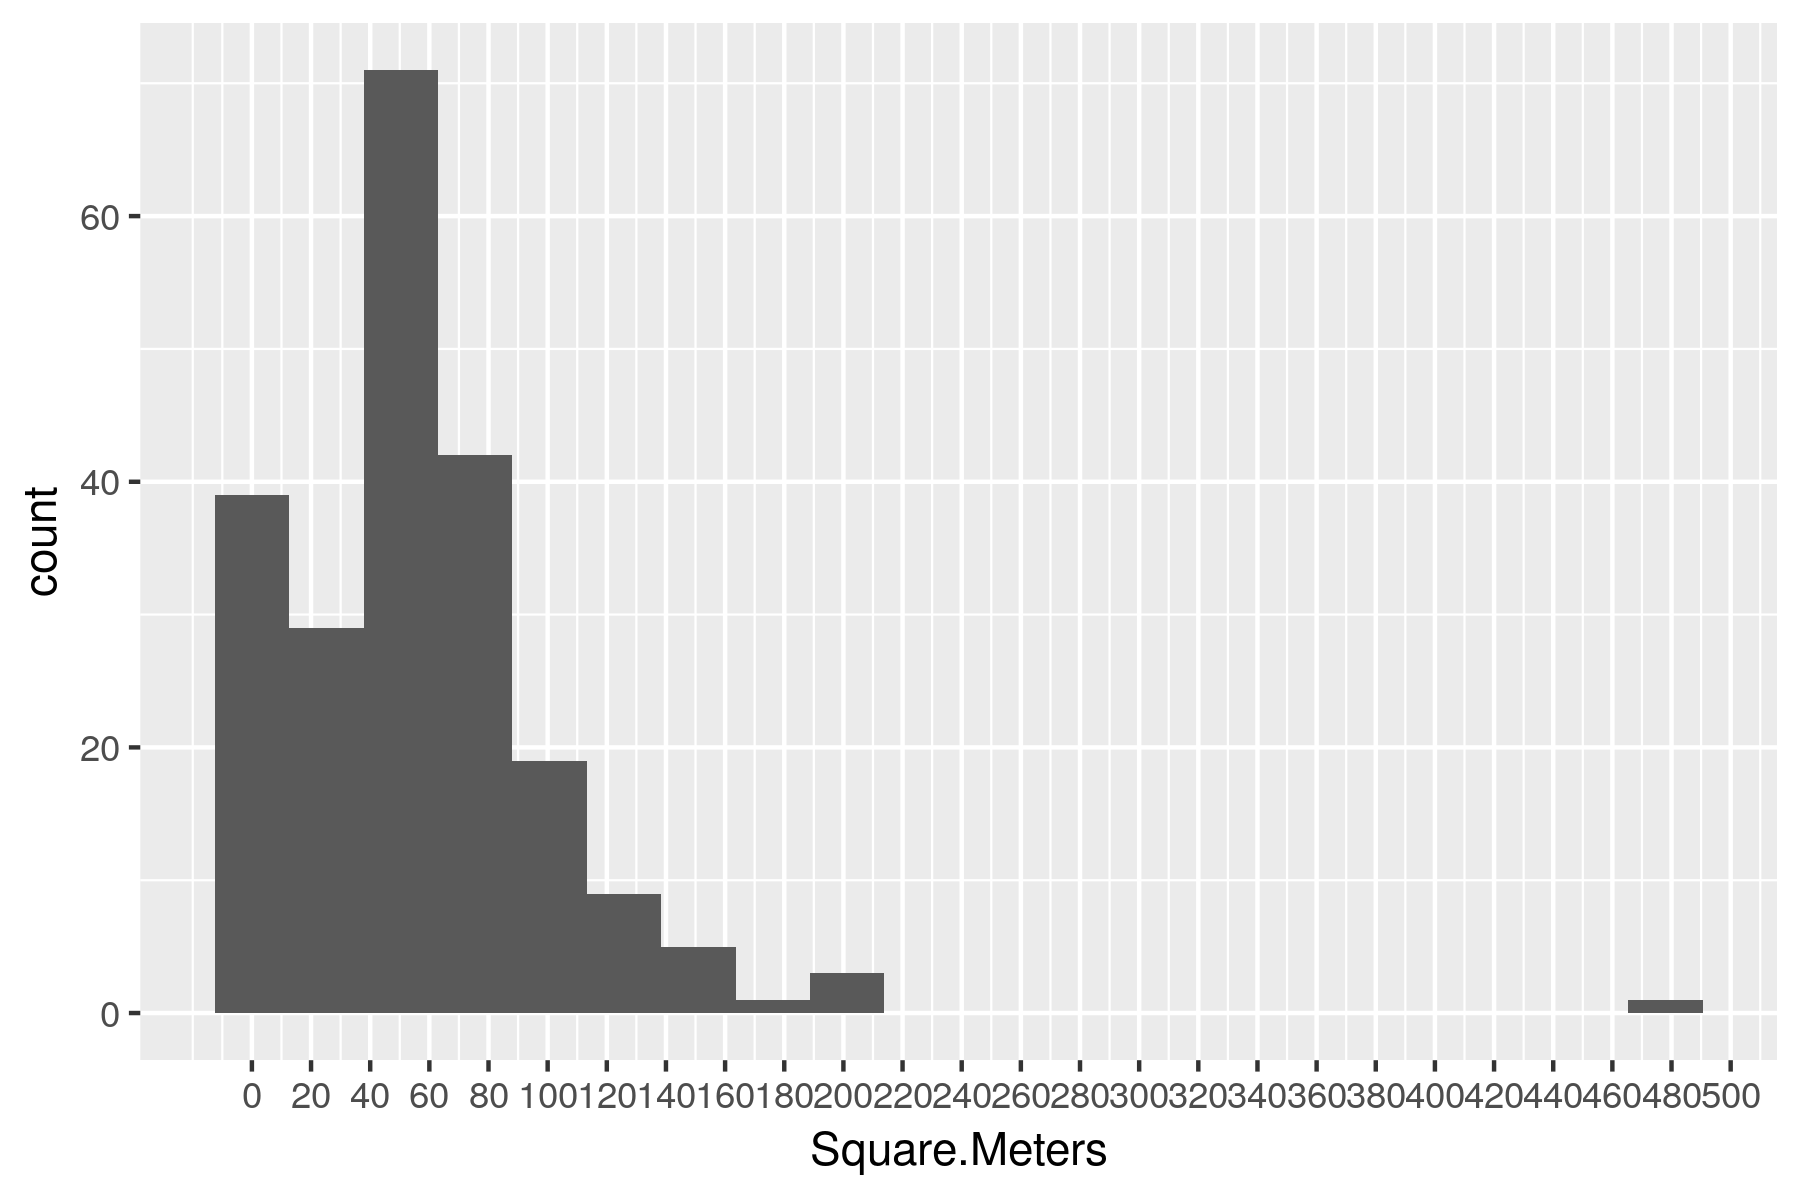

In [9]:
ggplot(data=df_madrid, aes(x=Square.Meters))+
    geom_histogram(bins=20)+
    scale_x_continuous(breaks = seq(0, 600, by = 20))

Asigna el valor NA a la columna Square.Meters de los apartamentos que tengan menos de 20 m^2

In [10]:
df_madrid$Square.Meters[df_madrid$Square.Meters < 20] <- NA

Existen varios Barrios que todas sus entradas de Square.Meters son NA, vamos a eliminar del dataset todos los pisos que pertenecen a estos barrios.

In [11]:
# Agrupo DF por barrios y cuento cuandos valores de m2 distintos a NA hay en cada barrio.
# Si no tiene ningun valor distinto a NA, ese barrio debera ser eliminado.
df_group_barrios <- df_madrid |> group_by(Neighbourhood) |>
    summarise("Cantidad de pisos con m2 != NA" = sum(!is.na(Square.Meters)))

# Selecciona solo los barrios que tienen al menos un valor de m2 distinto a NA
df_barrios_sin_m2_NA <- df_group_barrios[df_group_barrios$"Cantidad de pisos con m2 != NA" > 0, "Neighbourhood"] 

# Convierte la lista de barrios de tibble a vector
barrios_sin_m2_NA <- pull(df_barrios_sin_m2_NA,Neighbourhood)

# Selecciona del DF original, solo esos barrios.
df_madrid <- df_madrid[df_madrid$Neighbourhood %in% barrios_sin_m2_NA,]


In [12]:
paste('Luego de filtrar quedaron',
      df_madrid$Neighbourhood |> unique() |> length(),
      'barrios y',
      df_madrid |> nrow(),
      'entradas')


[1] "Luego de filtrar quedaron 38 barrios y 4901 entradas"

El barrio parece ser un indicador importante para los metros cuadrados de un apartamento.

Vamos a agrupar los barrios por metros cuadrados. Podemos usar una matriz de similaridad de Tukey tal y como hicimos en el curso de estadística:


Attaching package: ‘reshape2’


The following object is masked from ‘package:tidyr’:

    smiths




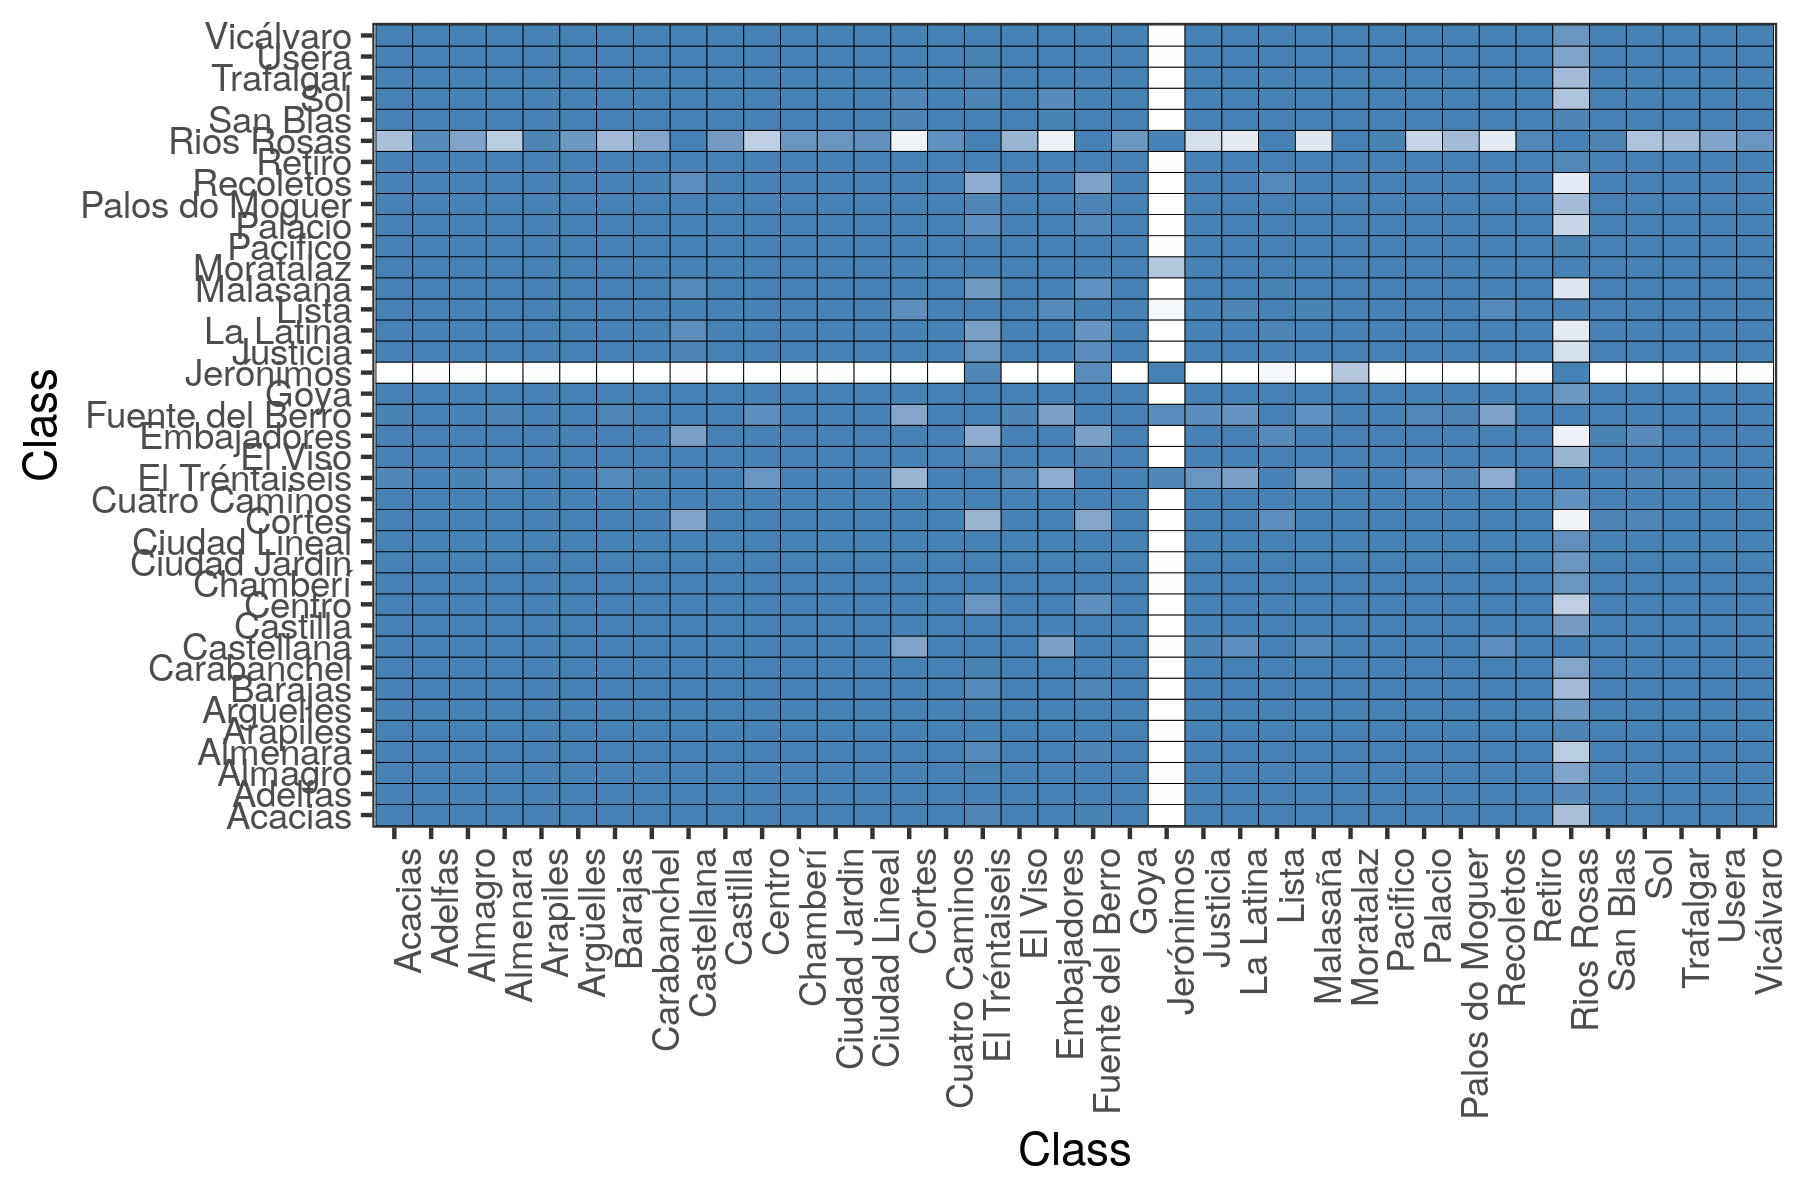

In [13]:
tky<-TukeyHSD(aov( formula=Square.Meters~Neighbourhood, data=df_madrid ))
tky.result<-data.frame(tky$Neighbourhood)
cn <-sort(unique(df_madrid$Neighbourhood))
resm <- matrix(NA, length(cn),length(cn))
rownames(resm) <- cn
colnames(resm) <- cn
resm[lower.tri(resm) ] <- round(tky.result$p.adj,4)
resm[upper.tri(resm) ] <- t(resm)[upper.tri(resm)] 
diag(resm) <- 1
library(ggplot2)
library(reshape2)
dfResm <- melt(resm)
ggplot(dfResm, aes(x=Var1, y=Var2, fill=value))+
  geom_tile(colour = "black")+
  scale_fill_gradient(low = "white",high = "steelblue")+
  ylab("Class")+xlab("Class")+theme_bw()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1),legend.position="none")

Usando como variable de distancia: 1-resm
Dibuja un dendrograma de los diferentes barrios.


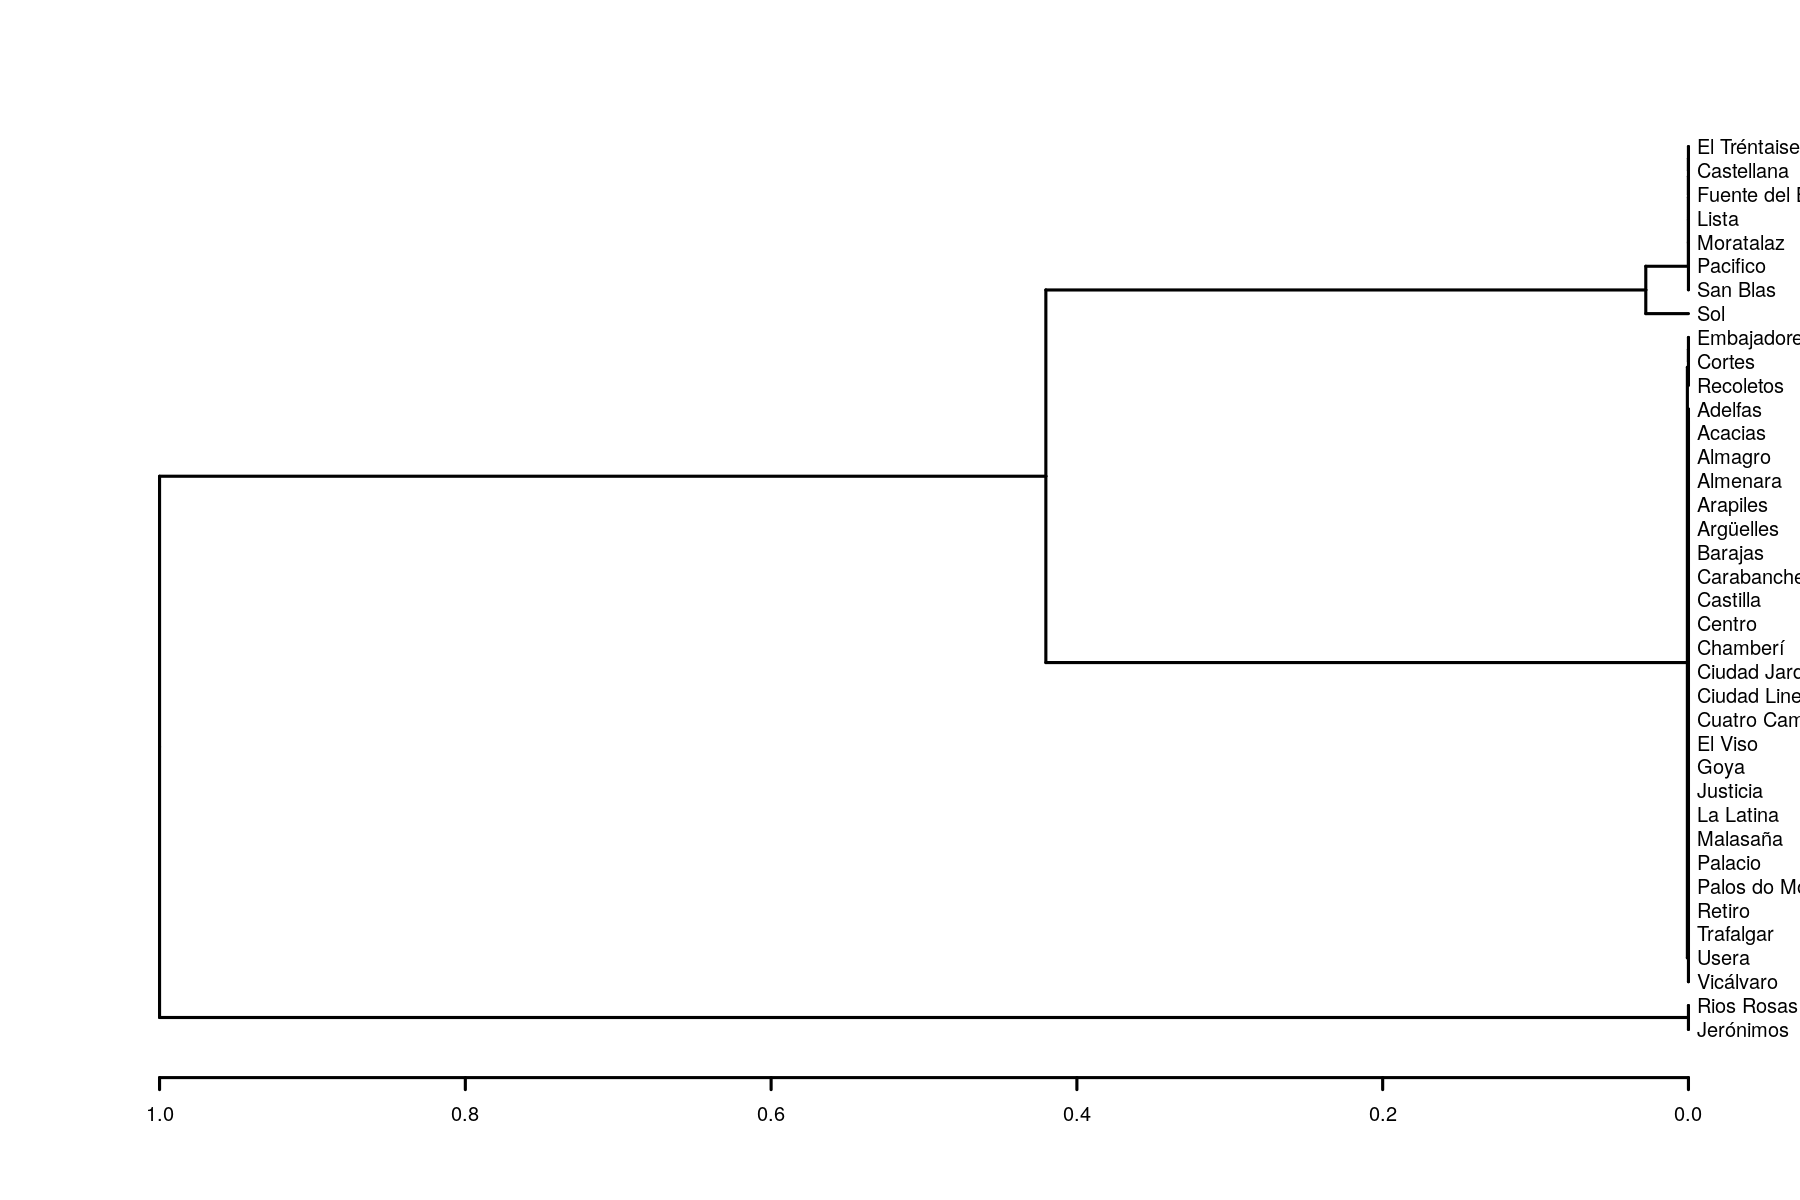

In [14]:
# Calculo de matriz de distancias
d <- as.dist(1-resm)

hc <- hclust(d,method="complete")
#hc <- hclust(d,method="average")
#hc <- hclust(d,method="centroid")

hcd <- as.dendrogram(hc)
par(cex=0.4)
plot(hcd, horiz=TRUE)


¿Que punto de corte sería el aconsejable?, ¿cuantos clusters aparecen?

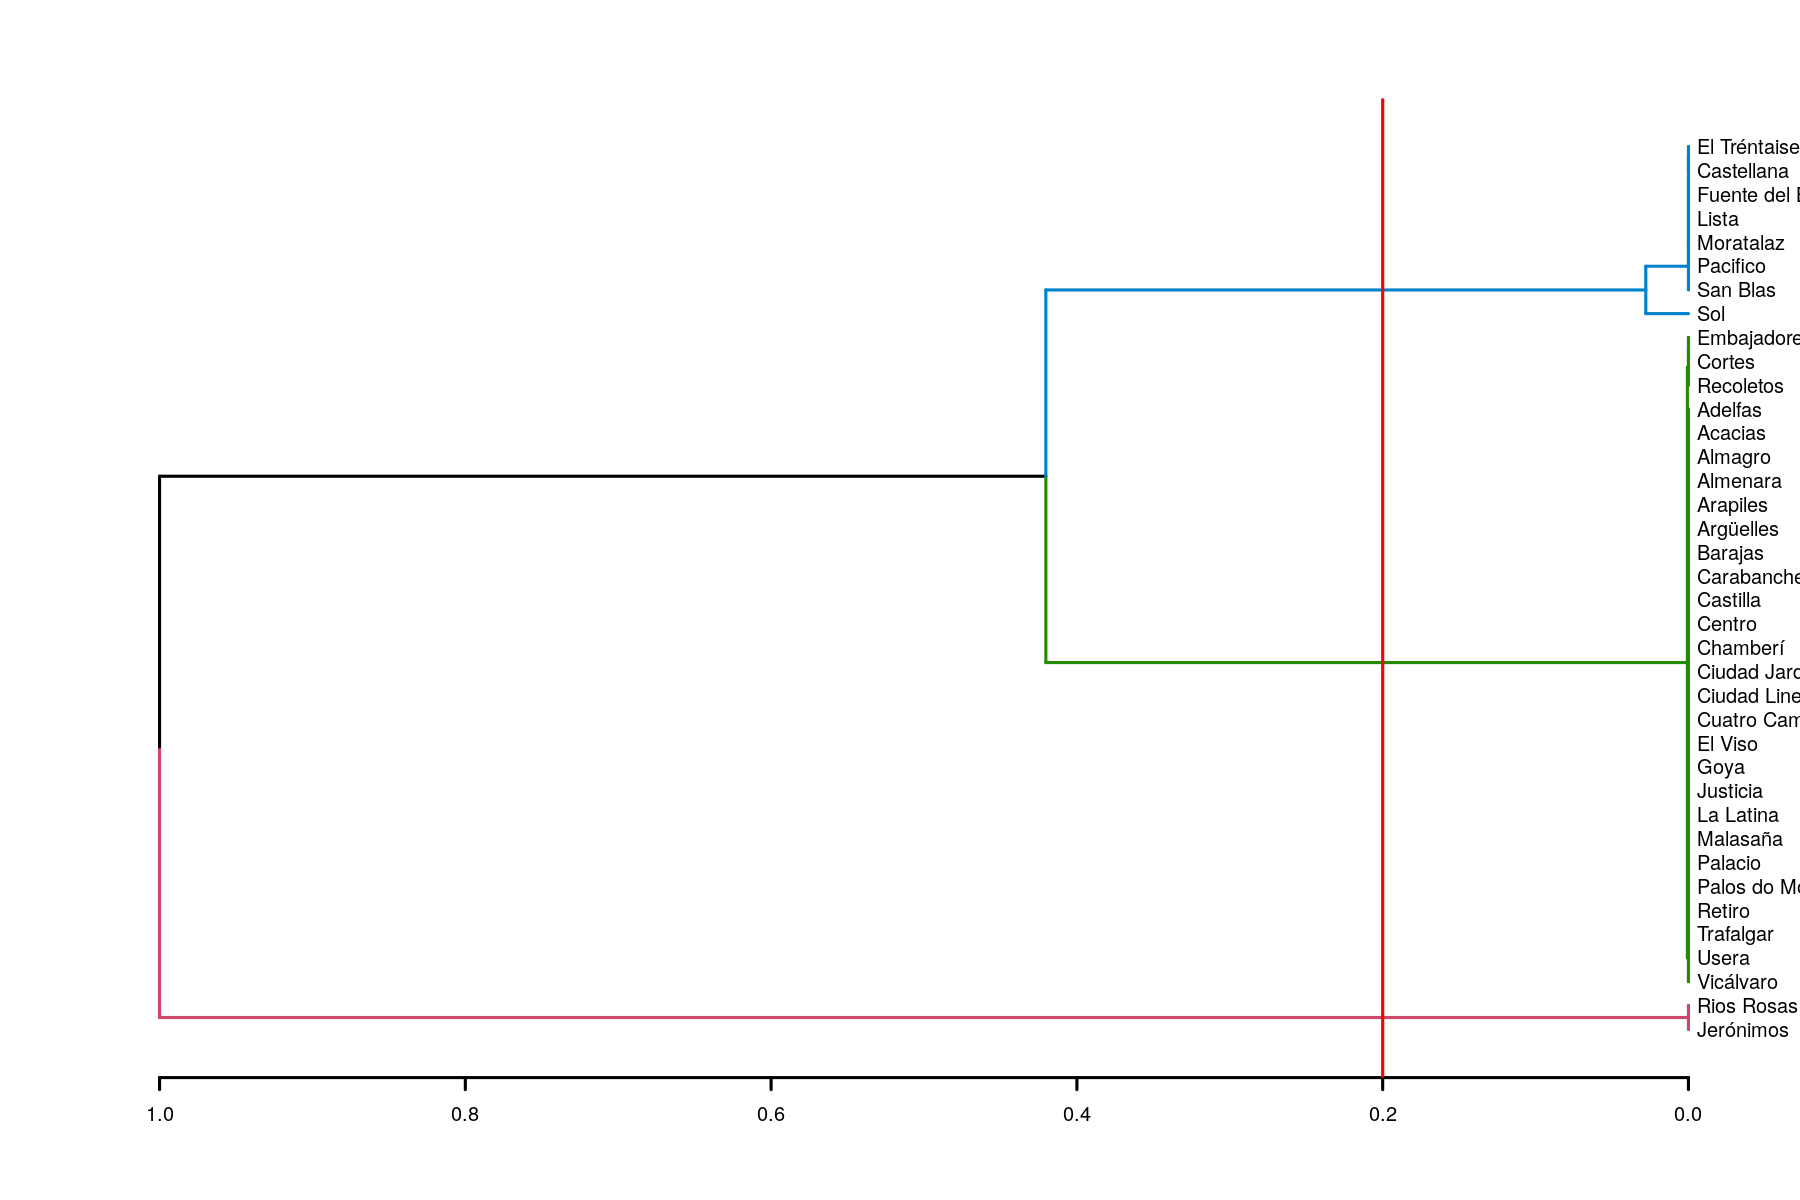

In [15]:
# Se podria realicar un corte en 0.2, creando 3 clusters
h_cut = 0.2
par(cex=0.4)
plot(color_branches(hcd,h=h_cut),horiz=TRUE)
abline(v=h_cut,col="red")

Vamos a crear una nueva columna en el dataframe df_madrid con un nuevo identificador marcado por los clusters obtenidos. Esta columna la llamaremos neighb_id

In [16]:
# Lista con el id del cluster al cual pertenece cada barrio
Group_n <- cutree_1h.dendrogram(hcd, h=h_cut)
#Group_n <- cutree(hcd, k = 3)

# Crea un dataframe con el nombre de cada barrio y el id del cluster (neighb_id) al cual pertenece
df_neighb_id <- data.frame(Neighbourhood = barrios_sin_m2_NA, neighb_id = Group_n)

# Agrega a df_madrid una columna indicando el cluster al que pertene cada departamento en funcion del barrio
df_madrid <- merge(x=df_madrid, y=df_neighb_id, by= "Neighbourhood")

In [17]:
df_madrid$Neighbourhood <- as.factor(df_madrid$Neighbourhood)
df_madrid$neighb_id <- as.factor(df_madrid$neighb_id)

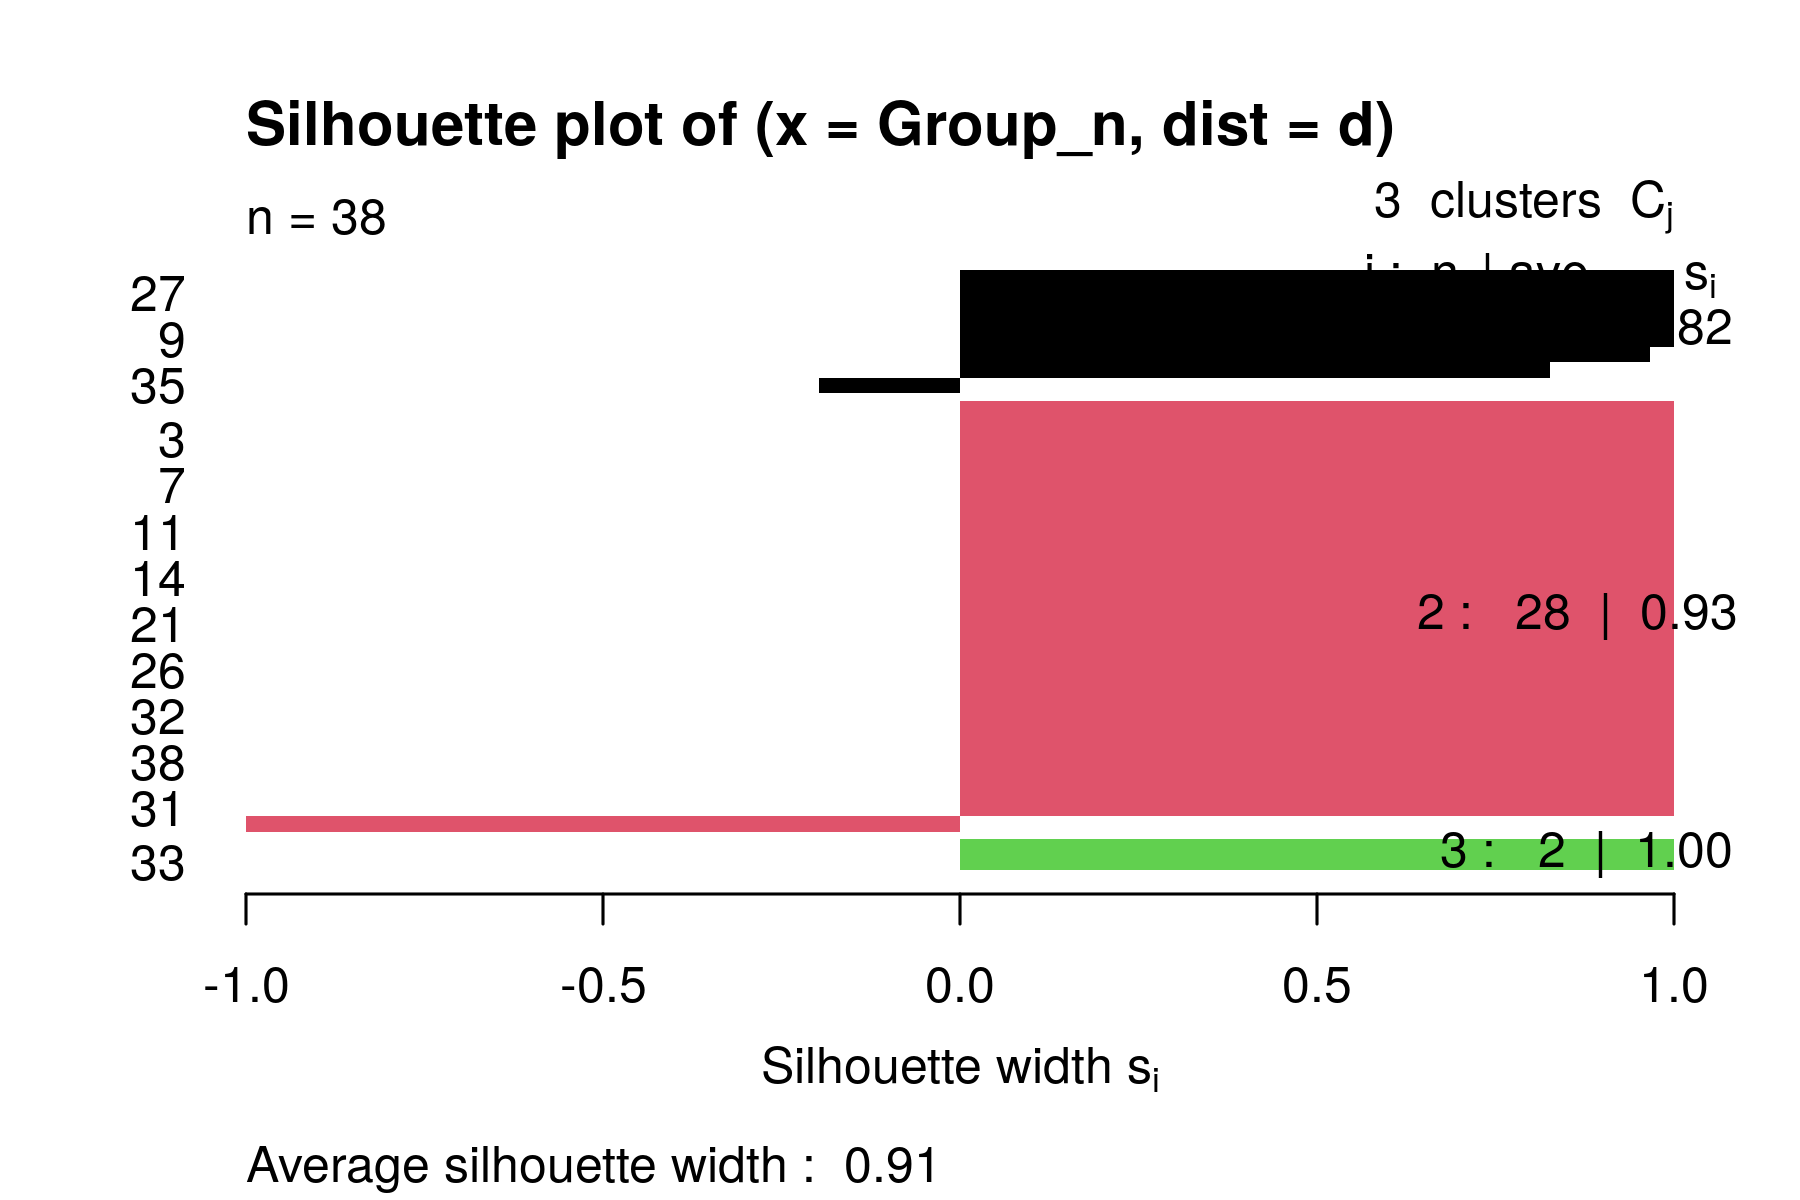

In [18]:
ss <- silhouette(Group_n, d)
plot(ss, col=1:max(Group_n), border=NA)

Vamos a crear dos grupos, uno test y otro train.

Tratamos de predecir los metros cuadrados en función del resto de columnas del dataframe.

In [19]:
# Se utilizan solo las entradas que tienen un valor de Square.Meters != NA
df_madrid_noNA <- df_madrid |> filter(!is.na(Square.Meters))
paste("Hay", df_madrid_noNA |> nrow(), "entradas con Square.Meters != NA:" )

#Se crean los grupos de test y train
set.seed(123)
idx<-sample(1:nrow(df_madrid_noNA),nrow(df_madrid_noNA)*0.7)

df_madrid_noNA.train=df_madrid_noNA[idx,]
df_madrid_noNA.test=df_madrid_noNA[-idx,]
paste("El grupo de train tiene", nrow(df_madrid_noNA.train) ,"entradas")
paste("El grupo de test tiene", nrow(df_madrid_noNA.test) ,"entradas")

[1] "Hay 174 entradas con Square.Meters != NA:"

[1] "El grupo de train tiene 121 entradas"

[1] "El grupo de test tiene 53 entradas"

In [20]:
model_madrid<-lm(Square.Meters~Accommodates+Bathrooms+Bedrooms+
                 Beds+Price+Guests.Included+Extra.People+
                 Review.Scores.Rating+neighb_id,
                 data=df_madrid_noNA.train)
summary(model_madrid)


Call:
lm(formula = Square.Meters ~ Accommodates + Bathrooms + Bedrooms + 
    Beds + Price + Guests.Included + Extra.People + Review.Scores.Rating + 
    neighb_id, data = df_madrid_noNA.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-64.709 -11.700  -2.187  11.376  60.050 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)           -0.58703   20.35068  -0.029  0.97704    
Accommodates           2.39792    2.15577   1.112  0.26856    
Bathrooms             21.34545    5.02563   4.247 4.72e-05 ***
Bedrooms              18.36523    3.13501   5.858 5.54e-08 ***
Beds                  -2.40320    2.20090  -1.092  0.27739    
Price                  0.04454    0.03318   1.342  0.18243    
Guests.Included       -3.65989    2.09716  -1.745  0.08391 .  
Extra.People           0.81221    0.25237   3.218  0.00172 ** 
Review.Scores.Rating   0.15229    0.21493   0.709  0.48017    
neighb_id2           -12.53276    4.45961  -2.810  0.00592 ** 
nei

In [21]:
model_madrid<-lm(Square.Meters~Bathrooms+Bedrooms+Extra.People+neighb_id,
                 data=df_madrid_noNA.train)
summary(model_madrid)


Call:
lm(formula = Square.Meters ~ Bathrooms + Bedrooms + Extra.People + 
    neighb_id, data = df_madrid_noNA.train)

Residuals:
    Min      1Q  Median      3Q     Max 
-58.467 -11.364  -1.794   8.414  77.496 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   22.70687    6.57981   3.451 0.000784 ***
Bathrooms     17.49666    4.64297   3.768 0.000262 ***
Bedrooms      19.72645    2.47535   7.969 1.34e-12 ***
Extra.People   0.18817    0.08418   2.235 0.027338 *  
neighb_id2   -13.17044    4.50925  -2.921 0.004210 ** 
neighb_id3     5.47288   16.00646   0.342 0.733043    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 20.3 on 114 degrees of freedom
  (1 observation deleted due to missingness)
Multiple R-squared:  0.7303,	Adjusted R-squared:  0.7184 
F-statistic: 61.73 on 5 and 114 DF,  p-value: < 2.2e-16


Mirad el histograma de los residuos sobre el conjunto de test para evaluar la calidad de vuestro modelo

RMSE   Rsquared        MAE 
19.7896465  0.7302607 14.4875728

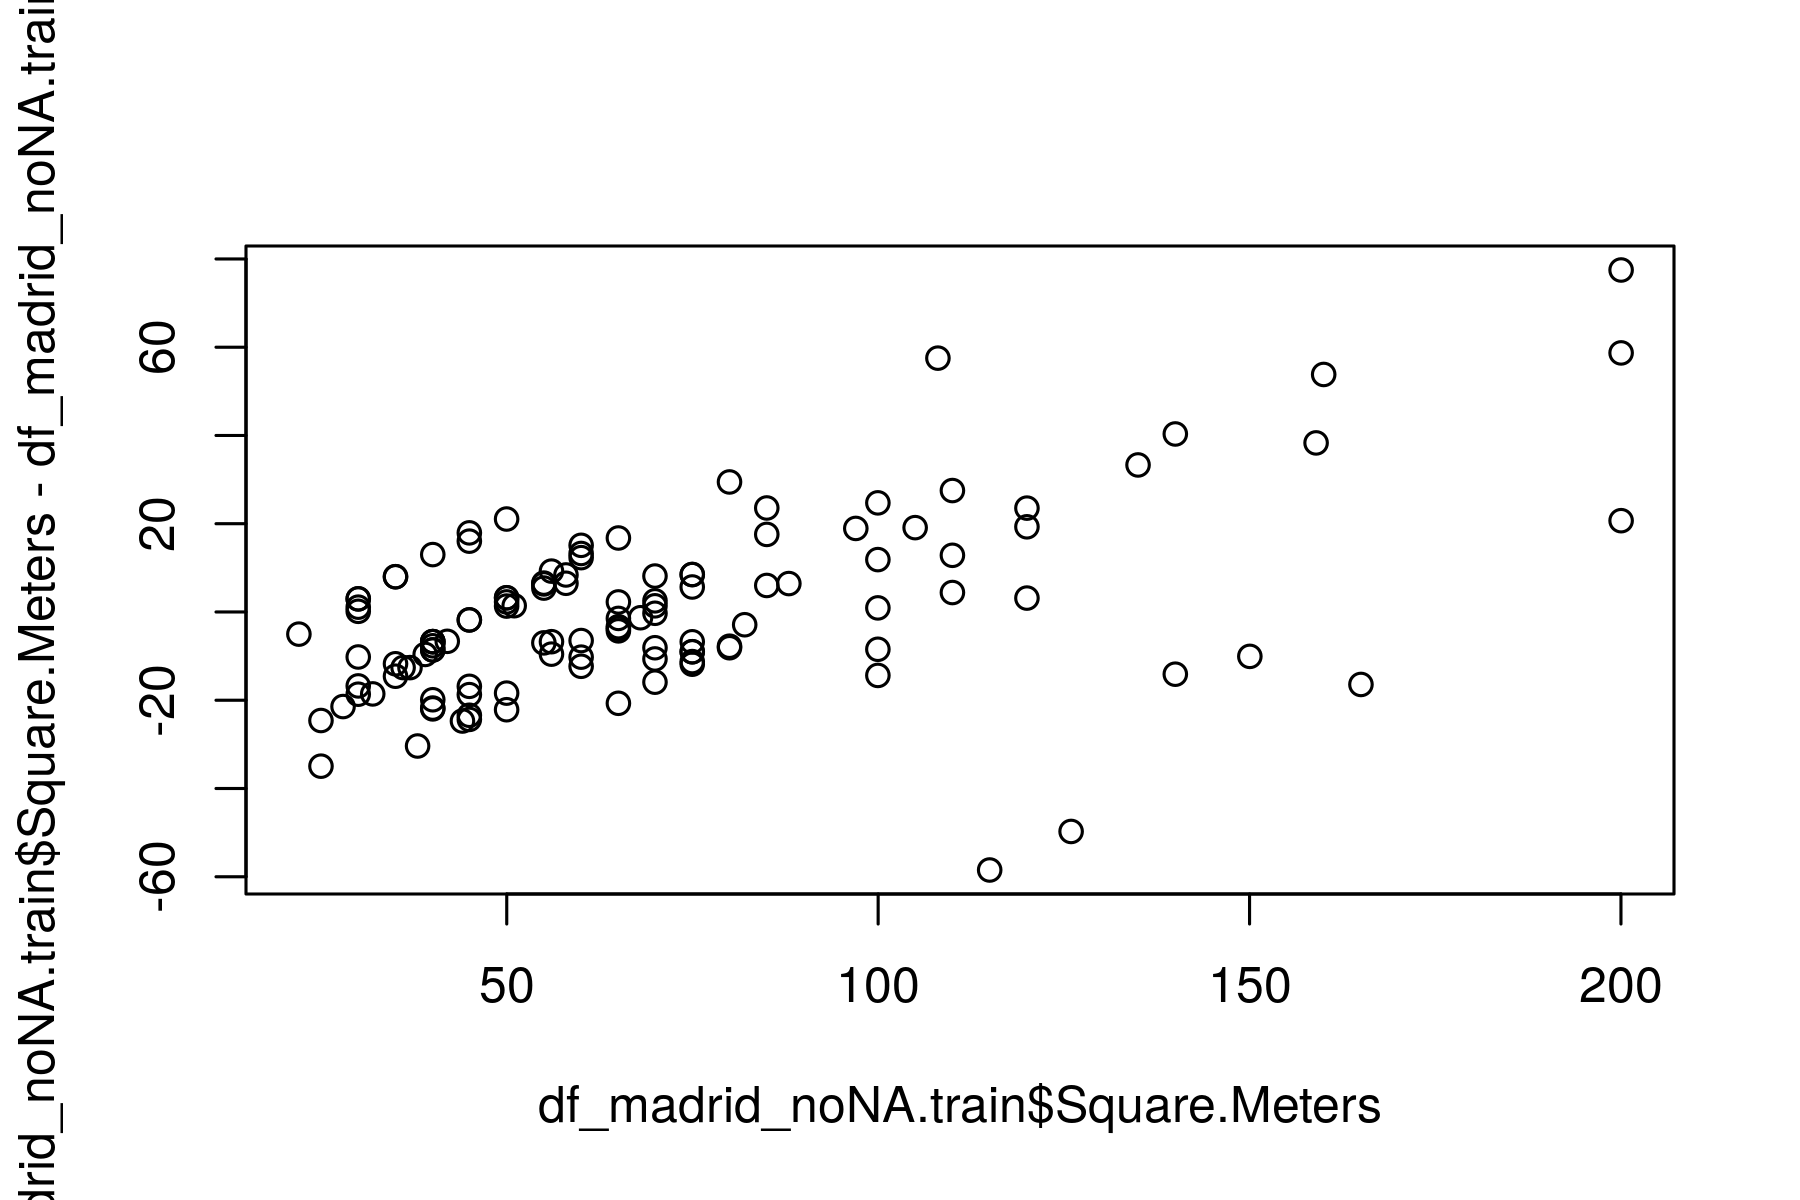

In [22]:
# Calculo de residuos usando el grupo de test
df_madrid_noNA.train$m2_est <- predict(model_madrid, df_madrid_noNA.train)

plot(df_madrid_noNA.train$Square.Meters,(df_madrid_noNA.train$Square.Meters-df_madrid_noNA.train$m2_est))

caret::postResample(pred=df_madrid_noNA.train$m2_est, obs= df_madrid_noNA.train$Square.Meters)

Si tuvieramos un anuncio de un apartamento para 6 personas (Accommodates), con 1 baño, con un precio de 80€/noche y 3 habitaciones en el barrio de Sol, con 3 camas y un review de 80.
¿Cuantos metros cuadrados tendría? Si tu modelo necesita algúna variable adicional puedes inventartela dentro del rango de valores del dataset.
¿Como varía sus metros cuadrados con cada habitación adicional?

In [25]:
# determino a que grupo de Neighbourhood pertenece el barrio de Sol
df_neighb_id[df_neighb_id$Neighbourhood=="Sol","neighb_id"]

[1] 1

In [26]:
# Como el barrio Sol pertenece al grupo 1 => neighb_id=1
# Asumo el valor de Extra.People=2


paste("La habitacion tendria", 
     round(predict(model_madrid, data.frame(Bathrooms=1, Bedrooms=3, Extra.People=2, neighb_id=as.factor(1))),digits = 2),
      "m2"
     )

[1] "La habitacion tendria 99.76 m2"

In [27]:
paste("Con cada habitacion adicional, los metros cuadrados aumentan: ",
    round(summary(model_madrid)$coefficients["Bedrooms","Estimate"], digits=2), "m2")

[1] "Con cada habitacion adicional, los metros cuadrados aumentan:  19.73 m2"

Rellenar los Square.Meters con valor NA con el estimado con el modelo anterior.

In [28]:
# DF solo con entradas con Square.Meters = NA
df_madrid_1 <- df_madrid[is.na(df_madrid$Square.Meters),]

# DF solo con entradas con Square.Meters != NA
df_madrid_2 <- df_madrid[!is.na(df_madrid$Square.Meters),]

In [29]:
# Reemplaza los NA de Square.Meters por el valor que calcula utilizando el modelo
df_madrid_1[,"Square.Meters"] <- predict(model_madrid, data.frame(
    Bathrooms=df_madrid_1$Bathrooms,
    Bedrooms=df_madrid_1$Bedrooms,
    Extra.People=df_madrid_1$Extra.People,
    neighb_id=df_madrid_1$neighb_id))

# Une el DF que contiene valores reales de Square.Meters, con el que contiene valores calculados
df_madrid <- rbind(df_madrid_1, df_madrid_2)

Usar PCA para encontrar el apartamento más cercano a uno dado.

Este algoritmo nos ayudaría a dado un apartamento que el algoritmo nos devolvería los 5 apartamentos más similares.


Crearemos una función tal que le pasemos un apartamento con los siguientes datos:
* Accommodates	
* Bathrooms	
* Bedrooms	
* Beds	
* Price	
* Guests.Included	
* Extra.People	
* Review.Scores.Rating	
* Latitude	
* Longitude	
* Square.Meters

y nos devuelva los 5 más similares de:

In [30]:
df_madrid <- na.omit(df_madrid)

pr_madrid <- prcomp(df_madrid[,c("Accommodates", "Bathrooms",
                                "Bedrooms", "Beds", "Price",
                                "Guests.Included", "Extra.People",
                                "Review.Scores.Rating", "Latitude",
                                "Longitude", "Square.Meters")],center = TRUE, scale. = TRUE)

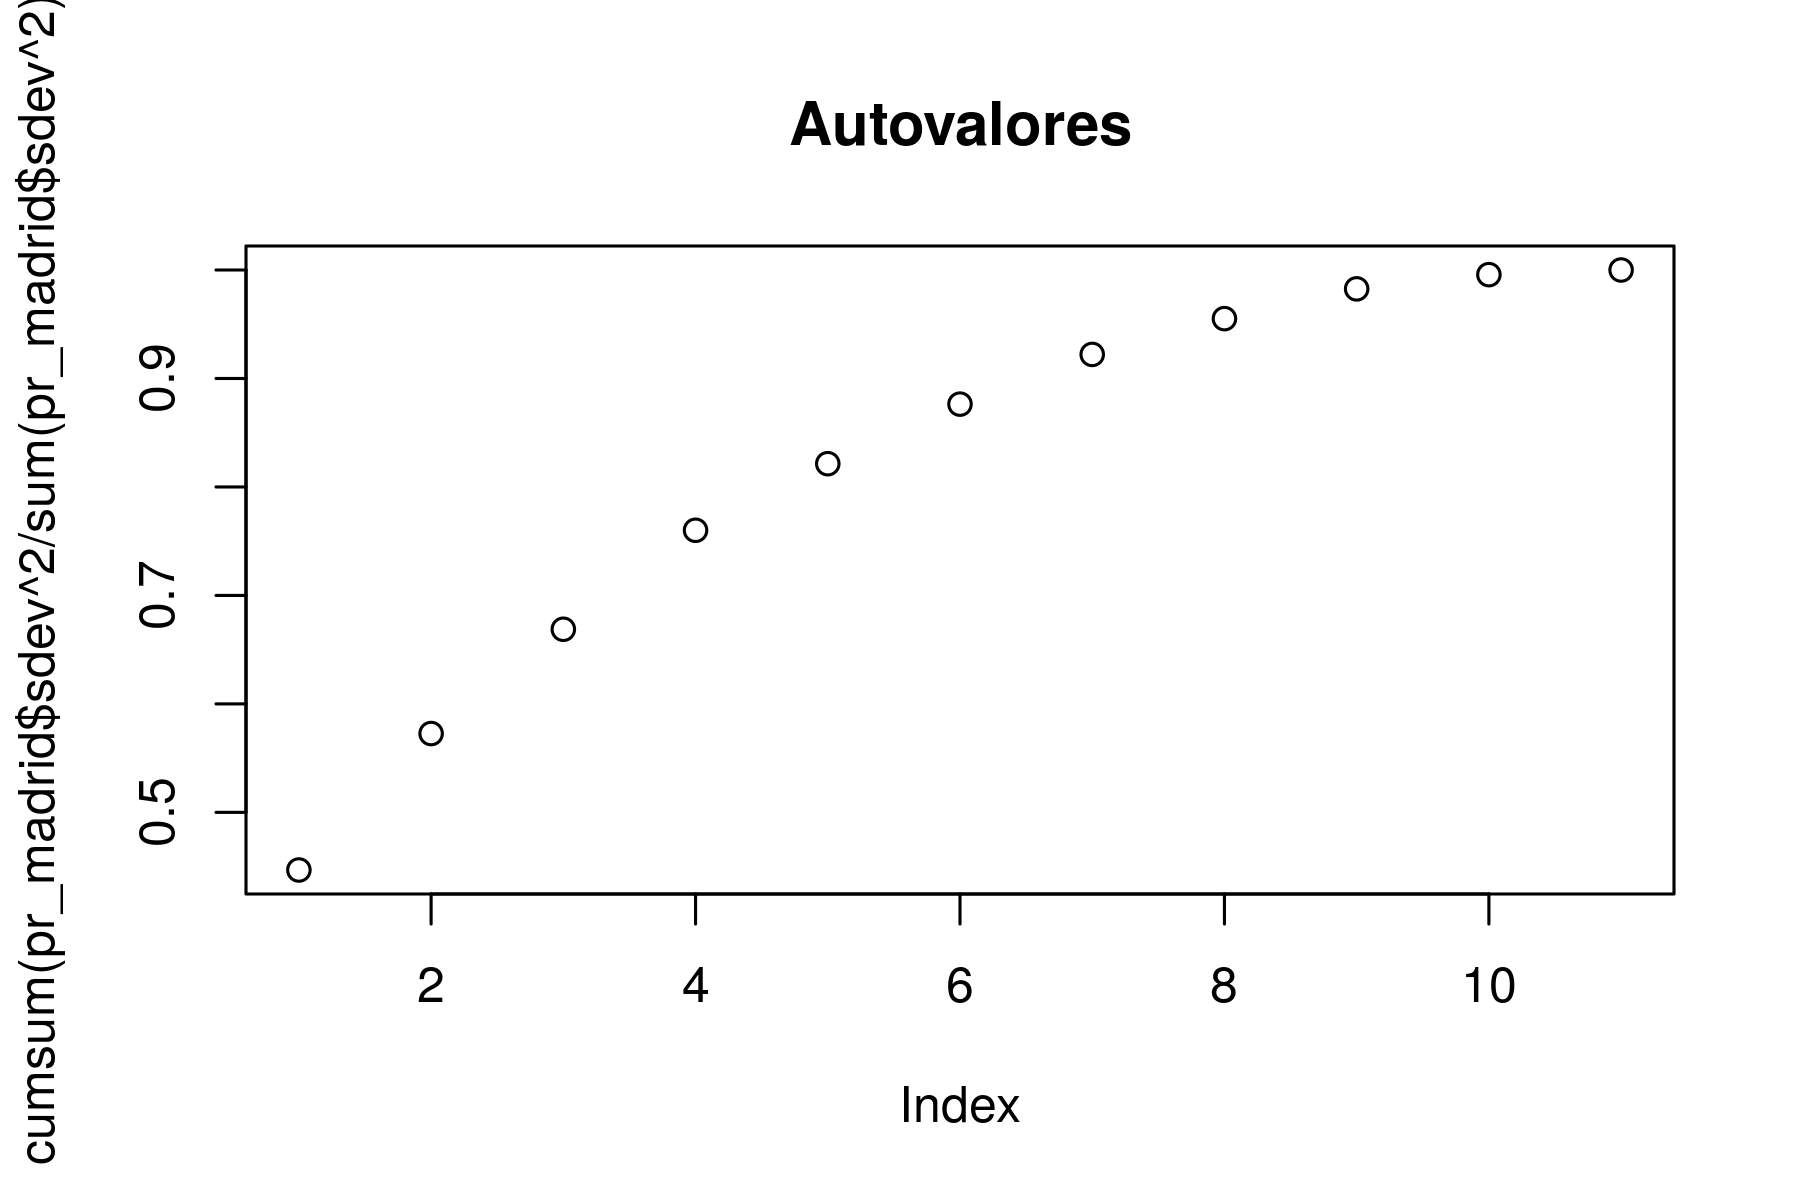

In [31]:
# Para determinar cuantos PCs usar, se grafica el acumulado de la suma de autovalores
plot(cumsum(pr_madrid$sdev^2/sum(pr_madrid$sdev^2)),main="Autovalores")


In [32]:
# Se utilizaran 4 vectores ya que representan en conjunto un valor cercano al 80%
n_pca <- 4
Apc <- pr_madrid$x[,1:n_pca]

In [33]:
find_closest_5 <- function(df_piso) {
    # Piso de prueba transformado
    piso_tr = predict(pr_madrid, df_piso)
    # Se mantienen solo los 4 primeros vectores del piso transformado
    piso_tr <- piso_tr[,1:n_pca]
    
    # Crea DF vacio para almacenar distancias e indicies
    dist <- data.frame(matrix(ncol = 2, nrow = 0))
    x <- c("index","dist_euclidean")
    colnames(dist) <- x

    # Guarda indices y distancias en DF
    for (i in 1:nrow(Apc)){
        dist[i,"index"] <- i
        dist[i,"dist_euclidean"] <- sum( (piso_tr-Apc[i,])^2 )
    }
    
    return(df_madrid[dist[order(dist$"dist_euclidean"),] |> head(5) |> pull("index"),])
}

In [34]:
# Genero un piso de prueba con los mismos valores que la fila df_madrid[100,]
# para luego poder comprbar que ese sea el piso al que mas se parece

piso_prueba <- data.frame(Accommodates=5, Bathrooms=1, Bedrooms=3, Beds=5,
                          Price=50, Guests.Included=5, Extra.People=20,
                          Review.Scores.Rating=93, Latitude=40.47142, Longitude=-3.696469, Square.Meters=89.9758 )

In [35]:
find_closest_5(piso_prueba)

,Neighbourhood,Accommodates,Bathrooms,Bedrooms,Beds,Price,Guests.Included,Extra.People,Review.Scores.Rating,Latitude,Longitude,Square.Meters,neighb_id
,<fct>,<int>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<fct>
154,Almenara,5,1,3,5,50,5,20,93,40.47142,-3.696469,89.97580,2
581,Ciudad Lineal,7,1,3,4,80,6,9,93,40.42982,-3.642413,87.90596,2
605,Ciudad Lineal,4,1,3,4,90,4,25,91,40.45141,-3.658379,90.91664,2
1088,Cuatro Caminos,6,1,2,5,80,4,20,94,40.45424,-3.692121,70.24935,2
587,Ciudad Lineal,6,1,3,5,60,2,20,95,40.42867,-3.634369,89.97580,2


Bonus: ¿de todas las coordenadas PCA cual es la que mejor permite clasificar por id de barrio?

¿Por qué?